##Deep Learning with Pytorch - Homework


## Import the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive

## Set up GPU capabilities


you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`.
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

In [ ]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.2.1+cu121
cuda:0


In [ ]:
device

device(type='cuda', index=0)

# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch`


## 1.1 Pytorch Dataset and DataLoader


### 1.1.1 Instantiate Dataset (for train/test dataset)
This script preprocesses the MNIST dataset by applying transformations, creating downsampled subsets for training and testing.

In [ ]:
scale = 28

import torchvision.transforms as transforms

# Define distortion scale for RandomPerspective
distortion_scale = 0.3

# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomRotation((-45, 45)),
    transforms.RandomPerspective(distortion_scale),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [ ]:

import torch
from torchvision import datasets
from torch.utils.data import Subset

# Initialize Dataset object for the training set
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Downsample training set
train_indices = torch.arange(0, len(train_dataset), step=2)
train_subset = Subset(train_dataset, train_indices)

# Initialize Dataset object for the testing set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Downsample testing set
test_indices = torch.arange(0, len(test_dataset), step=2)
test_subset = Subset(test_dataset, test_indices)

### 1.1.2 Dataloader - Train / Test

In [ ]:
batch = 64
# Initialize DataLoader object for train_subset
from torch.utils.data import DataLoader
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)

# Initialize DataLoader object for test_subset
test_loader = DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)

## 1.2 Summarizing our Dataset

### 1.2.1 Looking at the distribution of labels
This script creates DataLoaders for downsampled MNIST training and testing subsets, then counts and prints the label frequencies in both subsets.

In [ ]:
from torch.utils.data import DataLoader
# Use the original train dataset (with 60,000 images) object to obtain the number of label classes train data
train_num_labels = len(train_dataset.classes)

# Creating DataLoader for train subset
train_loader_bar_plot = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=0)

# Creating dictionary for train dataset
train_subset_dict = {}
for _, labels in train_loader_bar_plot:
    for label in labels:
        label = label.item()
        if label in train_subset_dict:
            train_subset_dict[label] += 1
        else:
            train_subset_dict[label] = 1

print(train_subset_dict)

{1: 3370, 4: 2958, 9: 3005, 2: 2996, 5: 2841, 0: 2819, 6: 2994, 7: 3149, 8: 2883, 3: 2985}


In [ ]:
# Use the original test dataset (with 10,000 images) object to obtain the number of label classes in test data
test_num_labels = len(test_dataset.classes)

# Creating DataLoader for test subset
test_loader_bar_plot = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=0)

# Creating dictionary for test dataset
test_subset_dict = {}
for _, labels in test_loader_bar_plot:
    for label in labels:
        label = label.item()
        if label in test_subset_dict:
            test_subset_dict[label] += 1
        else:
            test_subset_dict[label] = 1
print(test_subset_dict)

{2: 501, 5: 458, 0: 451, 7: 519, 6: 499, 1: 591, 8: 466, 3: 511, 9: 524, 4: 480}


### 1.2.2 Visualize through bar charts
This script visualizes the label frequencies of downsampled MNIST training and testing subsets using bar charts. It creates dataframes from the label dictionaries and plots the frequencies, adding value annotations for clarity


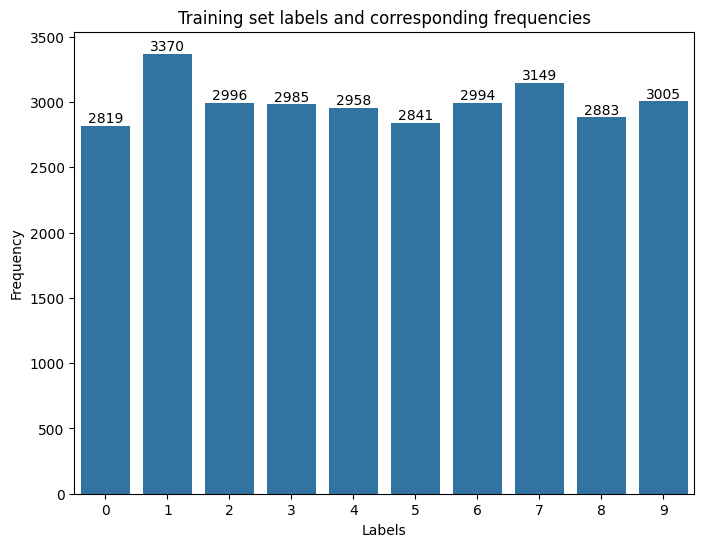

In [ ]:
# TRAIN Data

import matplotlib.pyplot as plt

train_subset_df = pd.DataFrame(list(train_subset_dict.items()), columns=['Labels', 'Frequency'])
train_subset_df = train_subset_df.sort_values('Labels', ascending = True)

plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(x='Labels', y='Frequency', data=train_subset_df)

for index, value in enumerate(train_subset_df['Frequency']):
        plt.text(index, value, str(value), color='black', ha='center', va='bottom')

plt.title("Training set labels and corresponding frequencies")

plt.show()



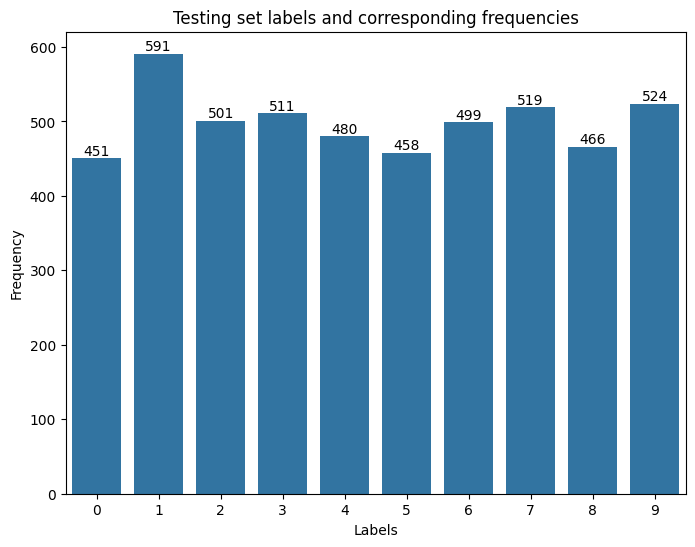

In [ ]:
# TEST Data

test_subset_df = pd.DataFrame(list(test_subset_dict.items()), columns=['Labels', 'Frequency'])
test_subset_df = test_subset_df.sort_values('Labels', ascending = True)

plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(x='Labels', y='Frequency', data=test_subset_df)

for index, value in enumerate(test_subset_df['Frequency']):
        plt.text(index, value, str(value), color='black', ha='center', va='bottom')

plt.title("Testing set labels and corresponding frequencies")

plt.show()


### 1.2.3 Visualize the Training Dataset
This script visualizes a selection of images from the downsampled MNIST training subset by plotting grayscale images with their corresponding labels. It uses specific sample indices and displays the images in a 2x3 grid layout.

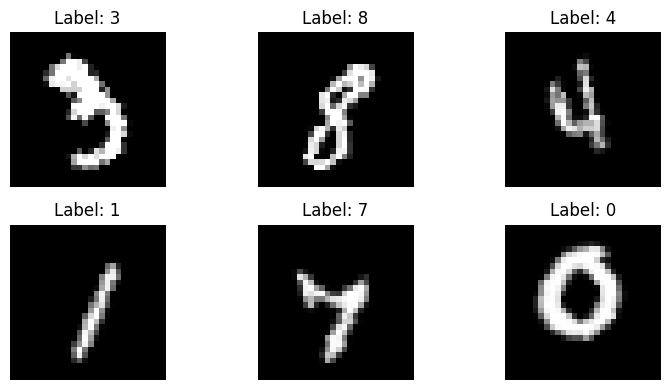

In [ ]:
torch.manual_seed(42)
sample_idxs = [10, 300, 700, 2708, 5035, 8000]

# loop through the length of tickers and keep track of index
import matplotlib.pyplot as plt

# Set overall figure size
plt.figure(figsize=(8, 4))

# Loop through sample indices and plot images
for i, idx in enumerate(sample_idxs):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[idx][0].squeeze(), cmap='gray')  # Plot image in grayscale
    plt.title(f'Label: {train_dataset[idx][1]}')
    plt.axis('off')

# Show plot
plt.tight_layout()
plt.show()


# **Part 2:** Classification Models

## 2.1 Logical Logistic Regression - Baseline

### 2.1.1 Logistic Regression Model Architecture

In [ ]:
import torch
import torch.nn as nn

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # implement the operations on input data
        outputs = nn.Sequential(self.flatten, self.linear, self.sigmoid)(x)
        return outputs

Let's print the model summary

In [ ]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

### 2.1.2 Training Logistic Regression Model
This script trains a logistic regression model on the downsampled MNIST dataset using PyTorch, iterating over 10 epochs. It tracks and prints the loss and accuracy for each epoch, storing these metrics for further analysis.



In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# Step 1: instantiate the logistic regression to variable logreg

logreg = LogReg().to(device)

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Logistic Regression
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = logreg(inputs)
      # Step 3: Get the prediction using argmax
      predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_log
  accuracy = 100 * correct / total
  if isinstance(accuracy, torch.Tensor):
      accuracy = accuracy.item()  # Convert Tensor to float
  acc_LIST_log.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  average_loss = running_loss / len(train_loader)
  if isinstance(average_loss, torch.Tensor):
      average_loss = average_loss.item()  # Convert Tensor to float
  loss_LIST_log.append(average_loss)

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.1079002537452842, Accuracy = 43.913333333333334
The loss for Epoch 1 is: 1.9496660491805087, Accuracy = 58.64
The loss for Epoch 2 is: 1.8963445168314204, Accuracy = 60.69
The loss for Epoch 3 is: 1.8690196712896514, Accuracy = 61.526666666666664
The loss for Epoch 4 is: 1.8513911060178712, Accuracy = 62.153333333333336
The loss for Epoch 5 is: 1.8374765219210563, Accuracy = 62.77
The loss for Epoch 6 is: 1.8292158544699013, Accuracy = 63.05
The loss for Epoch 7 is: 1.8219611494780095, Accuracy = 63.223333333333336
The loss for Epoch 8 is: 1.8135018902800992, Accuracy = 63.63666666666666
The loss for Epoch 9 is: 1.8115032949427297, Accuracy = 63.343333333333334
CPU times: user 6min 7s, sys: 1.47 s, total: 6min 9s
Wall time: 6min 13s


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression
This script visualizes the training accuracy of the logistic regression model over epochs using a line plot.

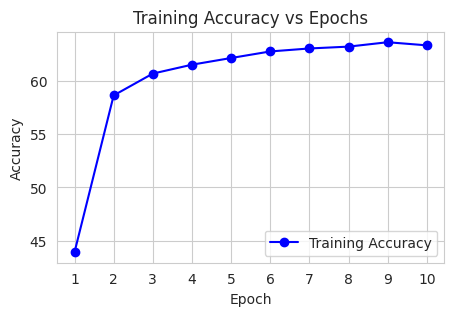

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(5, 3))  # Set the figure size as per the specifications

# Plot the accuracy vs epochs
# Assuming 'acc_LIST_log' contains the accuracy values and epoch starts at 1
plt.plot(range(1, len(acc_LIST_log) + 1), acc_LIST_log, marker='o', color='blue', label='Training Accuracy')

# Add the title, and labels for the x and y axes
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Starting epoch label at 1 for interpretability as per the specifications
plt.xticks(range(1, len(acc_LIST_log) + 1))

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


### 2.1.4 Logistic Regression Model Accuracy

Calculate the Test Accuracy for the Logistic Regression Model we trained above.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = logreg(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)

        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()

# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = (correct / total) * 100

print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 63.540000915527344


### 2.2.1 Feedforward Neural Network Model Architecture (10 points)

In [ ]:
import torch.nn.functional as F
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        outputs = self.fc2(x)

        return outputs

Let's print the model summary

In [ ]:
FNN()

FNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

### 2.2.2 Training FNN Model
This script trains a Feedforward Neural Network (FNN) on the downsampled MNIST dataset using PyTorch over 10 epochs, tracking and printing the loss and accuracy for each epoch. The accuracy and average loss for each epoch are stored in lists for further analysis.

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# Step 1: instantiate the FNN model to variable fnn
fnn = FNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = fnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  average_loss = running_loss / len(train_loader)
  loss_LIST_FNN.append(average_loss)

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 1.3375304211685652, Accuracy = 59.36666666666667
The loss for Epoch 1 is: 0.9658641853312185, Accuracy = 70.00666666666666
The loss for Epoch 2 is: 0.8416976358082249, Accuracy = 74.17333333333333
The loss for Epoch 3 is: 0.7485736898267701, Accuracy = 77.04666666666667
The loss for Epoch 4 is: 0.667777261118899, Accuracy = 79.56
The loss for Epoch 5 is: 0.6176973614992618, Accuracy = 81.14
The loss for Epoch 6 is: 0.5789060158643133, Accuracy = 82.54666666666667
The loss for Epoch 7 is: 0.5285073295076773, Accuracy = 84.15666666666667
The loss for Epoch 8 is: 0.5028075224428035, Accuracy = 84.78333333333333
The loss for Epoch 9 is: 0.47335465563766993, Accuracy = 85.88666666666667
CPU times: user 6min 10s, sys: 1.41 s, total: 6min 12s
Wall time: 6min 13s


### 2.2.3 Plotting Training Accuracy vs Epochs FNN
This script visualizes the training accuracy of the Feedforward Neural Network (FNN) over epochs using a line plot.

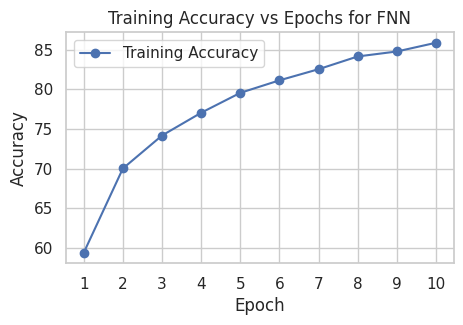

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(5, 3))

plt.plot(range(1, len(acc_LIST_FNN) + 1), acc_LIST_FNN, marker='o', linestyle='-', color='b', label='Training Accuracy')

plt.title('Training Accuracy vs Epochs for FNN')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(range(1, len(acc_LIST_FNN) + 1))

plt.legend()

plt.show()


### 2.2.4 FNN Model Accuracy

Calculate the Test Accuracy for the FNN Model we trained above

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = fnn(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()


# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = (correct / total) * 100
print('Test Accuracy: ' + str(test_acc_FNN.item()))

Test Accuracy: 86.53999328613281


##2.3 "Convoluted" Convolutional Neural Networks


### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers

In [ ]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  '''
  The function takes in the following four parameters and return the dimension of the output feature map.

  input_dim: height/width of the input image
  kernel_size: size of the convolving kernel (aka. filter)
  padding: padding added to all four sides of the input in order to preserve the edges/borders
  stride: Stride of the convolution, or how many shifts per kernel

  ROUND DOWN if the result if a fraction.

  Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1
  '''
  output_dim = math.floor((input_dim + 2*padding - (kernel_size - 1) - 1) / stride + 1)

  return output_dim

### 2.3.1 Convolutional Neural Network Model Architecture
This script defines a Convolutional Neural Network (CNN) class in PyTorch, including two convolutional blocks, followed by flattening the 2D image into a 1D tensor and passing it through three fully-connected layers. The network structure includes activation functions and dropout layers to prevent overfitting.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Step 1: Initialize 1 - 3 convolution blocks (consists of a convolution layer, an activation function, a MaxPooling layer)

        ## you are encouraged to use the following comments to keep track of the output dimensions
        # input dim = __ channels, with image size __ x __
        # output dim = __ channels, with image size __ x __
        # Convolution Block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Block 2 ... Feel free to add 1 - 2 more convolution blocks
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Step 2: Flatten the 2D image into a 1D tensor
        self.flatten = nn.Flatten()

        # Step 3: Initialize 1-3 fully-connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.drop1 = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        # Step 1. Pass the images (x) through convolution block 1 and (block 2, 3 if you have built them)
        x = self.pool1(self.bn1(self.relu1(self.conv1(x))))
        x = self.pool2(self.bn2(self.relu2(self.conv2(x))))

        # Step 2. Flatten the image
        x = self.flatten(x)

        # Step 3. Pass the output through the fully-connected layers (remember to include activation function(s))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        outputs = self.fc3(x)

        return outputs

Let's print out the model summary

In [ ]:
CNN()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 2.3.2 Training CNN Model
This script trains a Convolutional Neural Network (CNN) on the downsampled MNIST dataset using PyTorch over 10 epochs, tracking and printing the loss and accuracy for each epoch. It resets the optimizer gradient, feeds the network with training data, computes the loss, performs backpropagation, and updates the model weights in each iteration. The training accuracy and average loss for each epoch are stored in lists for further analysis.

In [ ]:
%%time
# Sending the data to device (CPU or GPU)

# Step 1: instantiate the CNN model to variable cnn
cnn = CNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = cnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      total += labels.size(0)
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = 100 * correct / total
  acc_LIST_CNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_CNN.append(epoch_loss)

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 1.5242578712607753, Accuracy = 47.94
The loss for Epoch 1 is: 0.7457397869909241, Accuracy = 76.47
The loss for Epoch 2 is: 0.5157874319980393, Accuracy = 84.33666666666667
The loss for Epoch 3 is: 0.4069268474700863, Accuracy = 87.91666666666667
The loss for Epoch 4 is: 0.3536601733328945, Accuracy = 89.62666666666667
The loss for Epoch 5 is: 0.3113443947264126, Accuracy = 91.07
The loss for Epoch 6 is: 0.2776297550561077, Accuracy = 91.89
The loss for Epoch 7 is: 0.25859674204514227, Accuracy = 92.51333333333334
The loss for Epoch 8 is: 0.24789868967969025, Accuracy = 92.97
The loss for Epoch 9 is: 0.2314060605697032, Accuracy = 93.43
CPU times: user 6min 24s, sys: 1.55 s, total: 6min 25s
Wall time: 6min 27s


### 2.3.3 Plotting Training Accuracy vs Epochs CNN
This script visualizes the training accuracy of the Convolutional Neural Network (CNN) over epochs using a line plot.

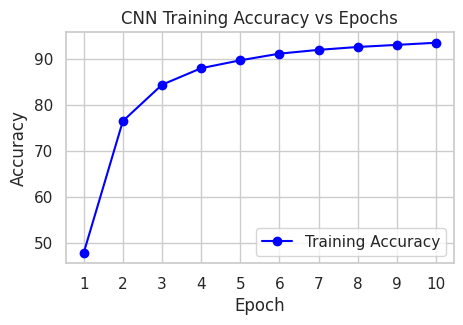

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a figure with specified size
plt.figure(figsize=(5, 3))

# Plot training accuracy vs epochs
# Note: Epochs are assumed to start from 1 for better interpretability
plt.plot(range(1, len(acc_LIST_CNN) + 1), acc_LIST_CNN, marker='o', linestyle='-', color='blue', label='Training Accuracy')

# Add chart title and labels for axes
plt.title('CNN Training Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Ensure the epoch labels start with 1
plt.xticks(range(1, len(acc_LIST_CNN) + 1))

# Add a legend
plt.legend()

# Show the plot
plt.show()


### 2.3.4 CNN Model Test Accuracy

Calculate the Test Accuracy for the CNN Model we trained above. Save it to the variable named `test_acc_CNN`.

In [ ]:

total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # Get the output
        outputs = cnn(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()

# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = (correct / total) * 100

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 94.5199966430664


## 2.4. Reflection



Let's compare the model performance:

From the test accuracies, we can see that FNN works better than Logistic Regression, and CNN works even better than FNN.

In [ ]:
# Simply run this cell, please do not modify
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log.item()))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN.item()))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN.item()))

Test Accuracy for Logistic Regression: 63.540000915527344
Test Accuracy for FNN: 86.53999328613281
Test Accuracy for CNN: 94.5199966430664


## 2.5 Confusion Matrix
This script generates and prints a confusion matrix for the Convolutional Neural Network (CNN) model's predictions on the downsampled MNIST test dataset. The confusion matrix is created using actual and predicted labels and is presented in a pandas DataFrame for better readability

### 2.5.1 Create a confusion matrix

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

def cm_generator(test_loader, model):
    actuals = []
    predictions = []

    with torch.no_grad():  # No need to track gradients
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            actuals.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(actuals, predictions)
    confusion_matrix_df = pd.DataFrame(cm, index=[f'Actual Class {i}' for i in range(len(cm))],
                                       columns=[f'Predicted Class {i}' for i in range(len(cm[0]))])

    return confusion_matrix_df

confusion_matrix_df = cm_generator(test_loader, cnn)

print(confusion_matrix_df)


                Predicted Class 0  Predicted Class 1  Predicted Class 2  \
Actual Class 0                436                  0                  3   
Actual Class 1                  1                575                  3   
Actual Class 2                  3                  1                467   
Actual Class 3                  3                  1                  6   
Actual Class 4                  0                  2                  4   
Actual Class 5                  1                  1                  1   
Actual Class 6                  5                  2                  2   
Actual Class 7                  1                  5                 11   
Actual Class 8                  3                  0                  4   
Actual Class 9                  1                  2                  0   

                Predicted Class 3  Predicted Class 4  Predicted Class 5  \
Actual Class 0                  1                  0                  1   
Actual Class 1          

### 2.5.2 Visualizing Confusion Matrix
This script visualizes the confusion matrix for the CNN model's predictions on the MNIST test dataset using a heatmap.








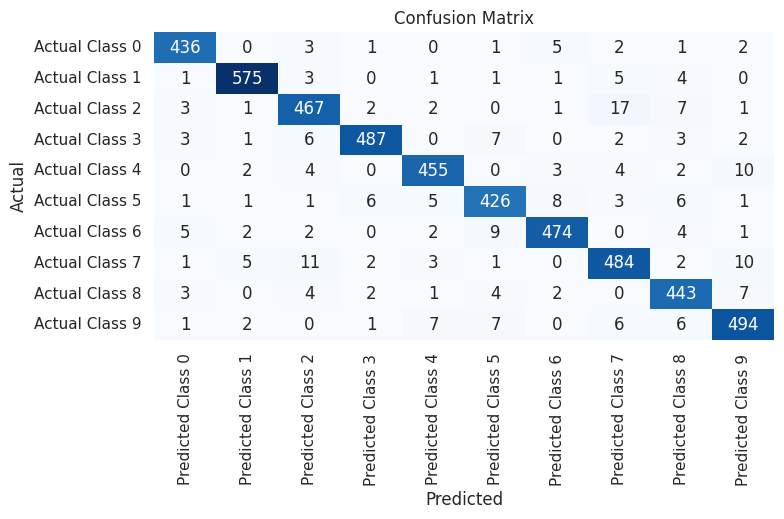

In [ ]:
# Set the seaborn style for better aesthetics
sns.set(style="white")

# Create a figure with specified size
plt.figure(figsize=(8, 4))

# Plot the heatmap
sns.heatmap(confusion_matrix_df, annot=True, fmt="g", cmap='Blues', cbar=False)

# Add chart title and labels for axes
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()
